# Directories

In [1]:
import os
mode = -1
mode = 'local'
# Install necessary files and create necessary folders (Only when ran in Google Drive)
!pip install snntorch==0.5.3
!pip install gym==0.25.2
!pip install box2d-py==2.3.5
!pip install torch==1.12.1+cu113
!pip install 
!pip install swig
!pip install gym
!pip install gym[box2d]
#!pip install gym[box2d]
!mkdir tmp
!mkdir logs
#from google.colab import drive
#drive.mount('/content/drive')
#!cp "/content/drive/MyDrive/Colab Notebooks/dict9 LIF" "/content/tmp/"
mode = 'colab'

ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0)
ERROR: No matching distribution found for torch==1.12.1+cu113
ERROR: You must give at least one requirement to install (see "pip help install")


# Imports

In [2]:
import gym
import time
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime
from collections import deque, namedtuple
from gym import wrappers
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.memory import mem_get_info
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate

import warnings
warnings.filterwarnings('ignore')

In [3]:
# A small method to save plots
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=resolution)

# Parameters ###

In [4]:
lr = 5e-4                   # Learning rate # lr = 0.001
batch_size = 128
gauss_per_dim = 64
max_episodes = 1000         # max num of episodes
max_timesteps = 2000        # max timesteps in one episode
num_steps = 16              # How many steps to loop in prediction
n_rounds = 5                # Number of competitive rounds to play

log_interval = 100          # print avg reward after interval
random_seed = 0
gamma = 0.99                # discount for future rewards
batch_size = 100            # num of transitions sampled from replay buffer
exploration_noise = 0.1
polyak = 0.995              # target policy update parameter (1-tau)
policy_noise = 0.2          # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2            # delayed policy updates parameter
start_episode = 0

In [5]:
env_name = 'BipedalWalker-v3'
env_name_clean = env_name.lower().replace('-','_')
filename = env_name_clean + ".png"
outfilename = env_name_clean + "scoreboard.txt"
datename = str(datetime.now()).split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_') 
scorefigname = env_name_clean + '_' + datename + '_scores.png'
epsfigname = env_name_clean + '_' + datename + '_eps_history.png'
cumfigname = env_name_clean + '_' + datename + '_cumulated_reward.png'
distfigname = env_name_clean + '_' + datename + '_distances.png'
meandistfigname = env_name_clean + '_' + datename + '_mean_distances.png'
model_file = './tmp/'  + env_name_clean + '_dict9'
model_file_target = model_file + '_target'
directory = "./tmp/"
filename = "TD3_{}_{}".format(env_name, random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Env name (clean):',env_name_clean)
print('Datetime (clean):', datename)
print('Output file:', outfilename)
print('Model file:', model_file)
print('Running training on: ', device)
print('Environment:', mode)

Env name (clean): bipedalwalker_v3
Datetime (clean): 2022_12_03_09_09_31
Output file: bipedalwalker_v3scoreboard.txt
Model file: ./tmp/bipedalwalker_v3_dict9
Running training on:  cuda
Environment: colab


# Classes

## Actor

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, beta=0.95):
        super(Actor, self).__init__()
        self.max_action = max_action
        
        # Initialize grad objects        
        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()

        # Initialize layers
        self.fc1 = nn.Linear(state_dim, 128)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        
        self.fc2 = nn.Linear(128, 128)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)

        self.fc3 = nn.Linear(128, action_dim)
        self.lif3 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad3)

    def _convert_to_spikes(self, data):
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [sigma, ] * self.numPerDim
        self.M = torch.tensor(np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float).to(device)
        self.sigma = torch.tensor(np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float).to(device)

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax).reshape(data.shape[0], -1)

    def forward(self, x, num_steps = 16):
        x = self.gaussianCurrents(x)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer#
        spk1_rec = []
        mem1_rec = []
        
        spk2_rec = []
        mem2_rec = []
        
        spk3_rec = []
        mem3_rec = []        

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return mem3_rec[num_steps-1]

## Critic

In [7]:
class Critic(nn.Module):
    def __init__(self, state_dim, beta=0.95):
        super(Critic, self).__init__()

        # Initialize grad objects        
        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()

        # Initialize layers
        self.fc1 = nn.Linear(state_dim, 128)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        
        self.fc2 = nn.Linear(128, 128)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)

        self.fc3 = nn.Linear(128, 1)
        self.lif3 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad3)

    def _convert_to_spikes(self, data):
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [sigma, ] * self.numPerDim
        self.M = torch.tensor(np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float).to(device)
        self.sigma = torch.tensor(np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float).to(device)

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax).reshape(data.shape[0], -1)

    def forward(self, state, action, num_steps = 16):
        x = torch.cat([state, action], 1)
        x = self.gaussianCurrents(x)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer#
        spk1_rec = []
        mem1_rec = []
        
        spk2_rec = []
        mem2_rec = []
        
        spk3_rec = []
        mem3_rec = []        

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return mem3_rec[num_steps-1]

## ReplayBuffer

In [8]:
class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

## Agent

In [9]:
class TD3:
    def __init__(self, lr, state_size, action_size, max_action, low, high, action_low, action_high, gauss_per_dim):
        state_dim = state_size * gauss_per_dim
        action_dim = action_size

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.actor.createGauss(low, high, gauss_per_dim, 1.0, state_size)
        self.actor_target.createGauss(low, high, gauss_per_dim, 1.0, state_size)

        critic_low = np.concatenate([low, action_low])         
        critic_high = np.concatenate([high, action_high])
        critic_input = (state_size + action_size) * gauss_per_dim

        self.critic_1 = Critic(critic_input).to(device)
        self.critic_1_target = Critic(critic_input).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_1.createGauss(critic_low, critic_high, gauss_per_dim, 1.0, state_size+action_size)
        self.critic_1_target.createGauss(critic_low, critic_high, gauss_per_dim, 1.0, state_size+action_size)
        
        self.critic_2 = Critic(critic_input).to(device)
        self.critic_2_target = Critic(critic_input).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.critic_2.createGauss(critic_low, critic_high, gauss_per_dim, 1.0, state_size+action_size)
        self.critic_2_target.createGauss(critic_low, critic_high, gauss_per_dim, 1.0, state_size+action_size)

        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()
            
            # Delayed policy updates:
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()
                
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))

        return actor_loss.cpu().data.numpy(), loss_Q1.cpu().data.numpy(), loss_Q2.cpu().data.numpy()
                
    def save(self, directory, name, ep):
        torch.save(self.actor.state_dict(), '%s/%s_actor_ep%s.pth' % (directory, name, ep))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target_ep%s.pth' % (directory, name, ep))
        
    def load(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        
    def load_actor(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))

# Setup

In [10]:
gym.logger.set_level(40)
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

policy = TD3(lr, 
             state_dim, 
             action_dim, 
             max_action, 
             env.observation_space.low, 
             env.observation_space.high, 
             env.action_space.low, 
             env.action_space.high, 
             gauss_per_dim)

replay_buffer = ReplayBuffer()

# logging variables:
scores = []
mean_scores = []
last_scores = deque(maxlen=log_interval)
distances = []
mean_distances = []
last_distance = deque(maxlen=log_interval)
losses_mean_episode = []

# Train

In [11]:
# training procedure:
for ep in range(start_episode + 1, max_episodes + 1):
    state = env.reset()
    total_reward = 0
    total_distance = 0
    actor_losses = []
    c1_losses = []
    c2_losses = []

    for t in range(max_timesteps):
        # select action and add exploration noise:
        action = policy.select_action(state)
        action = action + np.random.normal(0, exploration_noise, size=action.shape[0])
        action = action.clip(env.action_space.low, env.action_space.high)

        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state

        total_reward += reward
        if reward != -100:
            total_distance += reward

        # if episode is done then update policy:
        if done or t == (max_timesteps - 1):
            actor_loss, c1_loss, c2_loss = policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
            actor_losses.append(actor_loss)
            c1_losses.append((c1_loss))
            c2_losses.append(c2_loss)
            break

    mean_loss_actor = np.mean(actor_losses)
    mean_loss_c1 = np.mean(c1_losses)
    mean_loss_c2 = np.mean(c2_losses)
    losses_mean_episode.append((ep, mean_loss_actor, mean_loss_c1, mean_loss_c2))
    
    print('\rEpisode: {}/{},\tScore: {:.2f},\tDistance: {:.2f},\tactor_loss: {:.2f},\tc1_loss:{:.2f},\tc2_loss:{:.2f}'
        .format(ep, max_episodes,total_reward, total_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2), end="")

    # logging updates:
    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    FILE = 'record.dat'
    data = [ep, total_reward, total_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
    
    with open(FILE, "ab") as f:
        pickle.dump(data, f)

    # print avg reward every log interval:
    if ep % log_interval == 0:
        policy.save(directory, filename, str(ep))
        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        print('\rEpisode: {}/{},\tMean Score: {:.2f},\tMean Distance: {:.2f},\tactor_loss: {:.2f},\tc1_loss:{:.2f},\tc2_loss:{:.2f}'
            .format(ep, max_episodes, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2))
        
        FILE = 'record_mean.dat'
        data = [ep, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
        with open(FILE, "ab") as f:
            pickle.dump(data, f)
        
        if mean_score >= 300 and len(last_scores) == 100:
            print("Solved!")
            name = filename + '_solved'
            policy.save(directory, name, str(ep))
            break
env.close()

Episode: 100/1000,	Mean Score: -113.31,	Mean Distance: -13.31,	actor_loss: 26.29,	c1_loss:3.28,	c2_loss:6.44
Episode: 200/1000,	Mean Score: -101.51,	Mean Distance: -1.51,	actor_loss: 71.88,	c1_loss:1.22,	c2_loss:2.28
Episode: 300/1000,	Mean Score: -99.44,	Mean Distance: 0.56,	actor_loss: 78.08,	c1_loss:0.33,	c2_loss:0.41
Episode: 400/1000,	Mean Score: -100.02,	Mean Distance: -0.02,	actor_loss: 77.74,	c1_loss:0.20,	c2_loss:0.16
Episode: 500/1000,	Mean Score: -99.52,	Mean Distance: 0.48,	actor_loss: 79.66,	c1_loss:0.12,	c2_loss:0.09
Episode: 600/1000,	Mean Score: -99.00,	Mean Distance: 1.00,	actor_loss: 76.77,	c1_loss:0.09,	c2_loss:0.09
Episode: 700/1000,	Mean Score: -98.61,	Mean Distance: 1.39,	actor_loss: 75.59,	c1_loss:0.08,	c2_loss:0.10
Episode: 800/1000,	Mean Score: -98.97,	Mean Distance: 1.03,	actor_loss: 77.45,	c1_loss:0.09,	c2_loss:0.07
Episode: 900/1000,	Mean Score: -100.93,	Mean Distance: -0.93,	actor_loss: 78.45,	c1_loss:0.09,	c2_loss:0.14
Episode: 1000/1000,	Mean Score: -102.

# Plot

Saving figure bipedalwalker_v3_2022_12_03_09_09_31_scores.png


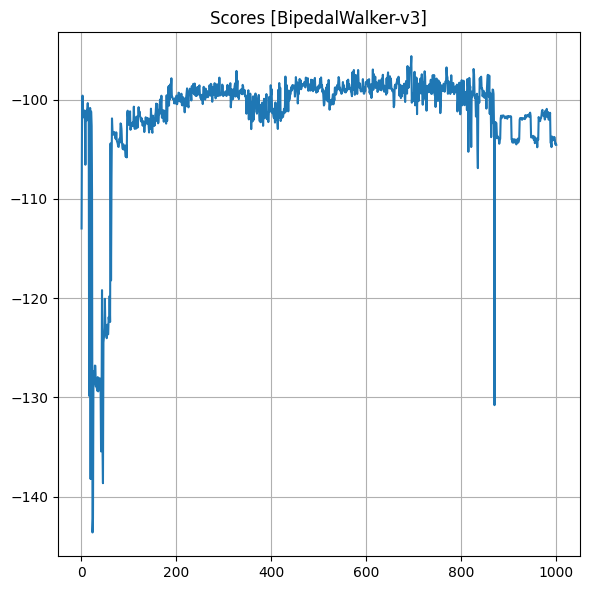

In [12]:
x = [idx + 1 for idx in range(len(scores))]

plt.figure(figsize=(6,6))
plt.plot(x, scores)
plt.title('Scores [' + env_name + ']')
plt.grid()
save_fig(scorefigname)
plt.show()

Saving figure bipedalwalker_v3_2022_12_03_09_09_31_cumulated_reward.png


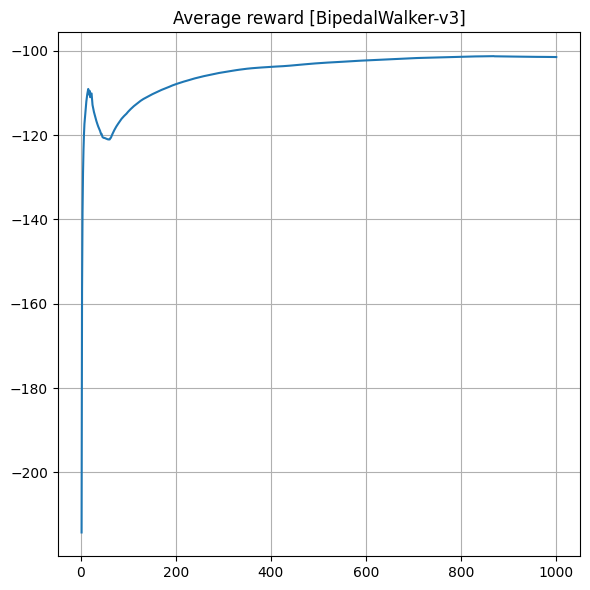

In [13]:
c_reward = np.cumsum(scores)
c_indices = np.arange(len(c_reward))
rolling_avg = c_reward / c_indices

plt.figure(figsize=(6,6))
plt.plot(x, rolling_avg)
plt.title('Average reward [' + env_name + ']')
plt.grid()
save_fig(cumfigname)
plt.show()

Saving figure bipedalwalker_v3_2022_12_03_09_09_31_distances.png


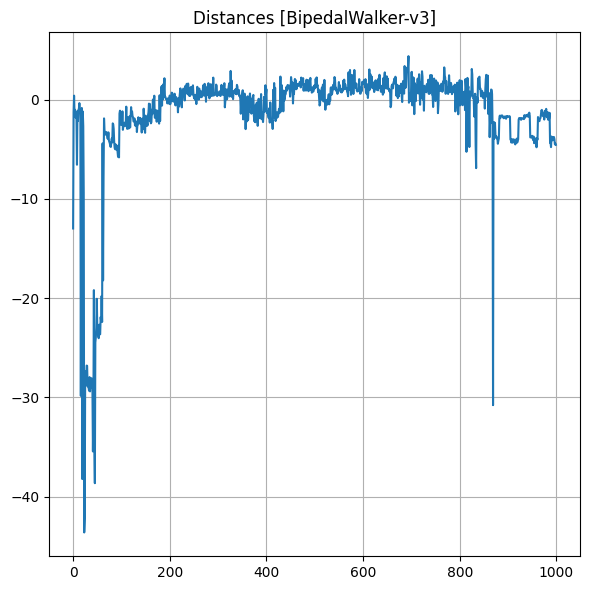

In [14]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(len(distances)), distances)
plt.title('Distances [' + env_name + ']')
plt.grid()
save_fig(distfigname)
plt.show()

Saving figure bipedalwalker_v3_2022_12_03_09_09_31_mean_distances.png


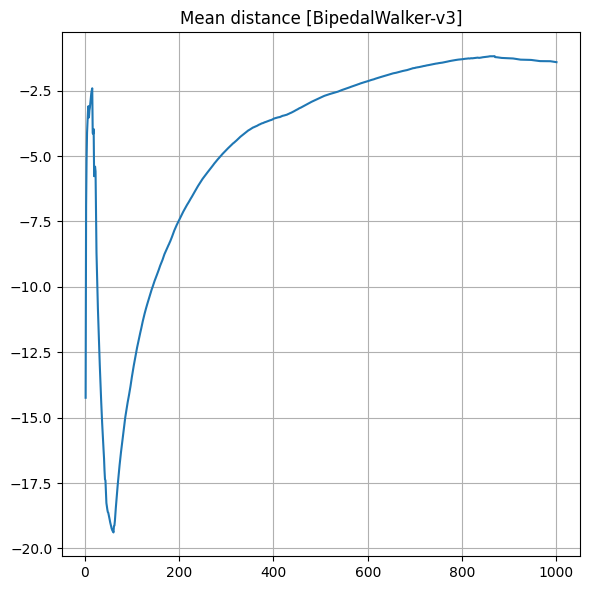

In [15]:
c_distances = np.cumsum(distances)
c_indices_distances = np.arange(len(c_distances))
rolling_avg_distances = c_distances / c_indices_distances

plt.figure(figsize=(6,6))
plt.plot(x, rolling_avg_distances)
plt.title('Mean distance [' + env_name + ']')
plt.grid()
save_fig(meandistfigname)
plt.show()

# Log

In [16]:
dfname = datename + '_runlogs'
df_avg_path = 'logs/' + env_name_clean + '_' + dfname + '_avg.csv'
df_dist_path = 'logs/' + env_name_clean + '_' + dfname + '_distances.csv'

df_avg = pd.DataFrame({'avg_score': rolling_avg})
df_dist = pd.DataFrame({'distances': distances})

df_avg.to_csv(df_avg_path, sep = ';', header = True, index = False)
df_dist.to_csv(df_dist_path, sep = ';', header = True, index = False)

print("Done logging results")

Done logging results


# Eval

In [18]:
compscores = 0
for i in range(n_rounds):
    done = False
    state = env.reset()
    score = 0

    while not done:        
        action = policy.select_action(state)
        
        next_state, reward, done, info = env.step(action)

        replay_buffer.add((state, action, reward, next_state, float(done)))
        
        state = next_state
        score += reward
    
    compscores += score
    print("Competitive round ", i + 1, " Overall score ", compscores)

Competitive round  1  Overall score  -104.4988476417667
Competitive round  2  Overall score  -206.608039381157
Competitive round  3  Overall score  -308.74972060613584
Competitive round  4  Overall score  -410.8568894647571
Competitive round  5  Overall score  -513.0866540410419


# Score

In [19]:
with open(outfilename, "w") as f:
    f.writelines("%s: %i\n" % (env_name_clean, compscores))